In [ ]:
##### MODELING LIBRARIES #####
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from patsy import dmatrices, dmatrix

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

##### TIMING AND UTILITY LIBRARIES #####
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [ ]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_load = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop all lag columns for us in RNN
lag_sq_cols = [column for column in df_load.columns if 'Lag' in column or 'Sq' in column]
df_load = df_load.drop(columns = lag_sq_cols)

# Drop null rows - should only be losing daylight savings in March
dropped = df_load.shape[0] - df_load.dropna().shape[0]
print('Dropping %s null values...'%(dropped))
df_load = df_load.dropna()

# Limit dataset to 13 months of data (18240 hours)
df_load.head(18240)

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour']:
    df_load[col] = df_load[col].astype('category')

In [ ]:
##### FINAL DATA PREPARATION #####
print("\nDefining testing and training set...") 

# Use Patsy to create the one-hot encoded dummy variables with interactions 
y, X =  dmatrices('value~Light+WWP+THI+Month+Day+WeekDay+Hour+Holiday',df_load,return_type='dataframe')

# Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

# Standardize both datasets - create fit to use on backcast dataset
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [ ]:
##### GRID SEARCH #####
print('/nBeginning grid search...')

# Define individual grid search parameters
param_dict = {'seq_length':[24, 48, 168],
              'seq_batch_size':[256, 512],
              'layer_one_neurons':[64, 128],
              'layer_two_neurons':[32, 64],
              'layer_three_neurons':[16, 32],
              'layer_four_neurons':[8, 16],
              'dropout_rate':[0, 0.2],
              'stop_patience':[4],
              'learning_rate':[0.001],
              'epochs':[40]
             }

# Create array of interactions between parameters
# Itertools approach taken from:
# https://stackoverflow.com/questions/798854/all-combinations-of-a-list-of-lists
df_params = pd.DataFrame(list(itertools.product(*param_dict.values())), columns = param_dict.keys())

# Add columns for tracking model performance
df_params['mse_train'],df_params['mse_test'],df_params['mape_train'],df_params['mape_test'] = [np.nan,np.nan,np.nan,np.nan]


Building and training models...
seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 66, dtype: float64
Epoch 1/40
69/69 [==============================] - 13s 194ms/step - loss: 8399363584.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 8347802112.0000 - val_mean_absolute_percentage_error: 99.9995
Epoch 2/40
69/69 [==============================] - 13s 188ms/step - loss: 8378436096.0000 - mean_absolute_percentage_error: 99.8677 - val_loss: 8327505920.0000 - val_mean_absolute_percentage_error: 99.8699
Epoch 3/40
69/69 [==============================] - 13s 187ms/step - loss: 7741116416.0000 - mean_absolute_percentage_error: 94.1172 - val_loss: 432784768.0000 - val_mean_absolute_percentage_error: 19.7299
Epoch 4/40


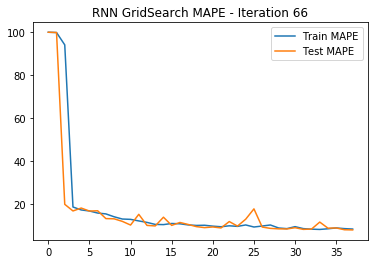

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 67, dtype: float64
Epoch 1/40
69/69 [==============================] - 14s 198ms/step - loss: 8202357248.0000 - mean_absolute_percentage_error: 98.7462 - val_loss: 7745685504.0000 - val_mean_absolute_percentage_error: 96.0622
Epoch 2/40
69/69 [==============================] - 13s 191ms/step - loss: 4892502528.0000 - mean_absolute_percentage_error: 71.9208 - val_loss: 6726920192.0000 - val_mean_absolute_percentage_error: 89.0676
Epoch 3/40
69/69 [==============================] - 13s 188ms/step - loss: 3262785536.0000 - mean_absolute_percentage_error: 57.1878 - val_loss: 5477158400.0000 - val_mean_absolute_percentage_error: 79.6867
Epoch 4/40
69/69 [==========================

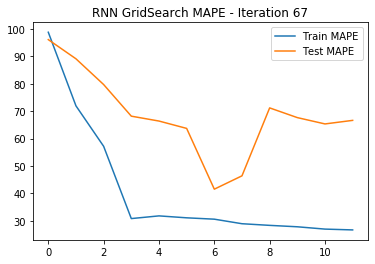

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 68, dtype: float64
Epoch 1/40
69/69 [==============================] - 16s 227ms/step - loss: 8338743808.0000 - mean_absolute_percentage_error: 99.6290 - val_loss: 8002007552.0000 - val_mean_absolute_percentage_error: 97.7777
Epoch 2/40
69/69 [==============================] - 15s 220ms/step - loss: 6898439168.0000 - mean_absolute_percentage_error: 89.6063 - val_loss: 2295346688.0000 - val_mean_absolute_percentage_error: 45.3614
Epoch 3/40
69/69 [==============================] - 15s 220ms/step - loss: 649577920.0000 - mean_absolute_percentage_error: 21.9455 - val_loss: 568016640.0000 - val_mean_absolute_percentage_error: 20.1176
Epoch 4/40
69/69 [============================

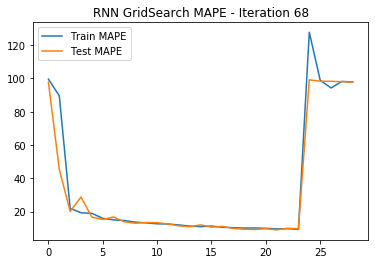

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 69, dtype: float64
Epoch 1/40
69/69 [==============================] - 17s 248ms/step - loss: 8213509120.0000 - mean_absolute_percentage_error: 98.8066 - val_loss: 8286605824.0000 - val_mean_absolute_percentage_error: 99.6073
Epoch 2/40
69/69 [==============================] - 16s 235ms/step - loss: 6082704384.0000 - mean_absolute_percentage_error: 80.1606 - val_loss: 5719564800.0000 - val_mean_absolute_percentage_error: 81.6405
Epoch 3/40
69/69 [==============================] - 16s 234ms/step - loss: 2769206528.0000 - mean_absolute_percentage_error: 48.9560 - val_loss: 3803573248.0000 - val_mean_absolute_percentage_error: 65.7337
Epoch 4/40
69/69 [==========================

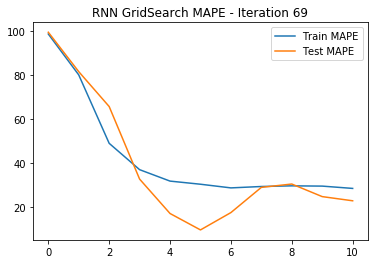

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 70, dtype: float64
Epoch 1/40
69/69 [==============================] - 17s 250ms/step - loss: 8137377792.0000 - mean_absolute_percentage_error: 98.2884 - val_loss: 7339092992.0000 - val_mean_absolute_percentage_error: 93.0229
Epoch 2/40
69/69 [==============================] - 17s 241ms/step - loss: 7937025536.0000 - mean_absolute_percentage_error: 97.0126 - val_loss: 7884416512.0000 - val_mean_absolute_percentage_error: 96.9859
Epoch 3/40
69/69 [==============================] - 17s 240ms/step - loss: 7876421120.0000 - mean_absolute_percentage_error: 96.5974 - val_loss: 7746597888.0000 - val_mean_absolute_percentage_error: 96.0642
Epoch 4/40
69/69 [==========================

Epoch 39/40
69/69 [==============================] - 16s 237ms/step - loss: 1091891328.0000 - mean_absolute_percentage_error: 30.0073 - val_loss: 1087307904.0000 - val_mean_absolute_percentage_error: 29.7883
Epoch 40/40
69/69 [==============================] - 17s 241ms/step - loss: 1090752896.0000 - mean_absolute_percentage_error: 29.9529 - val_loss: 1085843328.0000 - val_mean_absolute_percentage_error: 29.7869


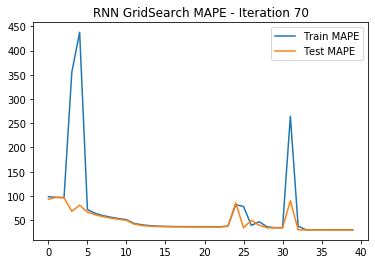

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 71, dtype: float64
Epoch 1/40
69/69 [==============================] - 19s 269ms/step - loss: 7110152704.0000 - mean_absolute_percentage_error: 90.6750 - val_loss: 6285924864.0000 - val_mean_absolute_percentage_error: 86.0203
Epoch 2/40
69/69 [==============================] - 18s 262ms/step - loss: 3157723392.0000 - mean_absolute_percentage_error: 54.7709 - val_loss: 2643509504.0000 - val_mean_absolute_percentage_error: 51.5568
Epoch 3/40
69/69 [==============================] - 18s 262ms/step - loss: 1735487616.0000 - mean_absolute_percentage_error: 37.8482 - val_loss: 2331823104.0000 - val_mean_absolute_percentage_error: 47.5758
Epoch 4/40
69/69 [==========================

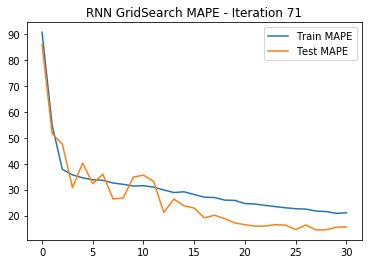

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 72, dtype: float64
Epoch 1/40
69/69 [==============================] - 19s 278ms/step - loss: 5896117248.0000 - mean_absolute_percentage_error: 77.9329 - val_loss: 879367744.0000 - val_mean_absolute_percentage_error: 28.7670
Epoch 2/40
69/69 [==============================] - 18s 268ms/step - loss: 34960752640.0000 - mean_absolute_percentage_error: 136.1682 - val_loss: 8297196544.0000 - val_mean_absolute_percentage_error: 99.6770
Epoch 3/40
69/69 [==============================] - 18s 267ms/step - loss: 8324828160.0000 - mean_absolute_percentage_error: 99.5215 - val_loss: 8216073728.0000 - val_mean_absolute_percentage_error: 99.1580
Epoch 4/40
69/69 [=========================

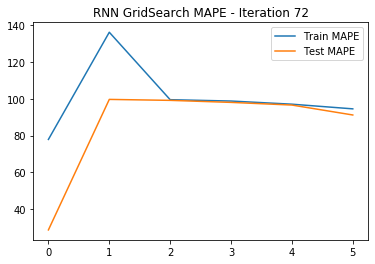

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 73, dtype: float64
Epoch 1/40
69/69 [==============================] - 19s 271ms/step - loss: 8378870272.0000 - mean_absolute_percentage_error: 99.5968 - val_loss: 8279014400.0000 - val_mean_absolute_percentage_error: 99.5569
Epoch 2/40
69/69 [==============================] - 18s 264ms/step - loss: 8354592768.0000 - mean_absolute_percentage_error: 99.7132 - val_loss: 8330731008.0000 - val_mean_absolute_percentage_error: 99.8896
Epoch 3/40
69/69 [==============================] - 18s 267ms/step - loss: 8351381504.0000 - mean_absolute_percentage_error: 99.6878 - val_loss: 8332154368.0000 - val_mean_absolute_percentage_error: 99.9006
Epoch 4/40
69/69 [==========================

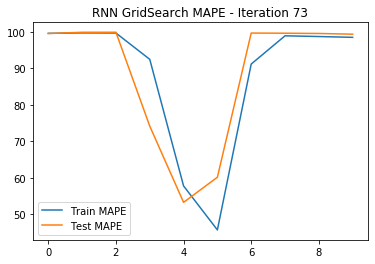

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 74, dtype: float64
Epoch 1/40
69/69 [==============================] - 19s 275ms/step - loss: 7255908864.0000 - mean_absolute_percentage_error: 88.0640 - val_loss: 1119412864.0000 - val_mean_absolute_percentage_error: 30.9326
Epoch 2/40
69/69 [==============================] - 19s 268ms/step - loss: 1251899904.0000 - mean_absolute_percentage_error: 32.3798 - val_loss: 986665152.0000 - val_mean_absolute_percentage_error: 28.7756
Epoch 3/40
69/69 [==============================] - 18s 267ms/step - loss: 30865260544.0000 - mean_absolute_percentage_error: 101.9398 - val_loss: 3463970816.0000 - val_mean_absolute_percentage_error: 60.8070
Epoch 4/40
69/69 [=========================

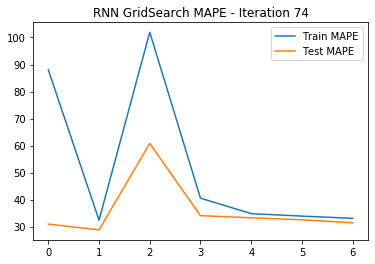

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 75, dtype: float64
Epoch 1/40
69/69 [==============================] - 20s 295ms/step - loss: 8304455168.0000 - mean_absolute_percentage_error: 99.3941 - val_loss: 8218225664.0000 - val_mean_absolute_percentage_error: 99.1587
Epoch 2/40
69/69 [==============================] - 20s 287ms/step - loss: 2421251328.0000 - mean_absolute_percentage_error: 44.3841 - val_loss: 807015168.0000 - val_mean_absolute_percentage_error: 24.5849
Epoch 3/40
69/69 [==============================] - 20s 288ms/step - loss: 1758090880.0000 - mean_absolute_percentage_error: 37.1573 - val_loss: 4893081088.0000 - val_mean_absolute_percentage_error: 75.6326
Epoch 4/40
69/69 [===========================

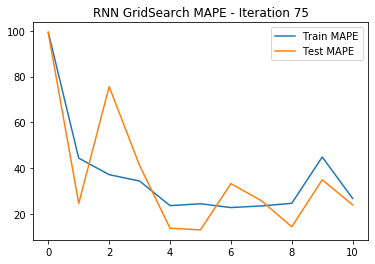

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 76, dtype: float64
Epoch 1/40
69/69 [==============================] - 21s 310ms/step - loss: 7364027392.0000 - mean_absolute_percentage_error: 93.3406 - val_loss: 6727124992.0000 - val_mean_absolute_percentage_error: 89.0614
Epoch 2/40
69/69 [==============================] - 21s 301ms/step - loss: 7720838656.0000 - mean_absolute_percentage_error: 95.5514 - val_loss: 7791197696.0000 - val_mean_absolute_percentage_error: 96.3870
Epoch 3/40
69/69 [==============================] - 21s 302ms/step - loss: 7752290304.0000 - mean_absolute_percentage_error: 95.7683 - val_loss: 7585968640.0000 - val_mean_absolute_percentage_error: 95.0161
Epoch 4/40
69/69 [==========================

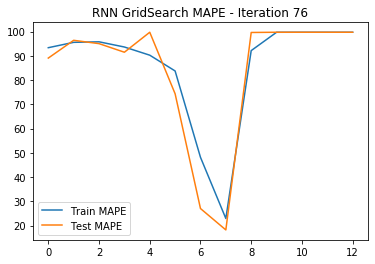

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 77, dtype: float64
Epoch 1/40
69/69 [==============================] - 21s 302ms/step - loss: 5998936064.0000 - mean_absolute_percentage_error: 78.4079 - val_loss: 7191867392.0000 - val_mean_absolute_percentage_error: 92.3559
Epoch 2/40
69/69 [==============================] - 21s 298ms/step - loss: 1595844736.0000 - mean_absolute_percentage_error: 34.2569 - val_loss: 958133952.0000 - val_mean_absolute_percentage_error: 29.6455
Epoch 3/40
69/69 [==============================] - 20s 293ms/step - loss: 1301339648.0000 - mean_absolute_percentage_error: 31.2378 - val_loss: 2305871872.0000 - val_mean_absolute_percentage_error: 49.2235
Epoch 4/40
69/69 [===========================

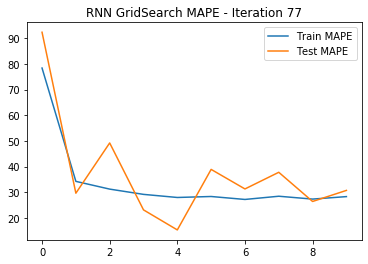

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 78, dtype: float64
Epoch 1/40
69/69 [==============================] - 20s 294ms/step - loss: 29815201792.0000 - mean_absolute_percentage_error: 132.0593 - val_loss: 655467216896.0000 - val_mean_absolute_percentage_error: 840.0640
Epoch 2/40
69/69 [==============================] - 20s 286ms/step - loss: 337497096192.0000 - mean_absolute_percentage_error: 274.4251 - val_loss: 1968821120.0000 - val_mean_absolute_percentage_error: 39.4078
Epoch 3/40
69/69 [==============================] - 19s 278ms/step - loss: 1970347520.0000 - mean_absolute_percentage_error: 39.3934 - val_loss: 1979608064.0000 - val_mean_absolute_percentage_error: 39.7373
Epoch 4/40
69/69 [==================

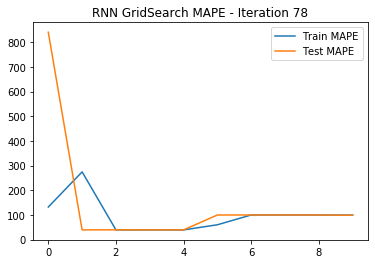

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 79, dtype: float64
Epoch 1/40
69/69 [==============================] - 22s 316ms/step - loss: 7569761280.0000 - mean_absolute_percentage_error: 94.4342 - val_loss: 5894163968.0000 - val_mean_absolute_percentage_error: 83.0668
Epoch 2/40
69/69 [==============================] - 21s 305ms/step - loss: 2202334464.0000 - mean_absolute_percentage_error: 42.8705 - val_loss: 671144384.0000 - val_mean_absolute_percentage_error: 21.9053
Epoch 3/40
69/69 [==============================] - 21s 304ms/step - loss: 1068140544.0000 - mean_absolute_percentage_error: 29.0973 - val_loss: 559320192.0000 - val_mean_absolute_percentage_error: 19.9370
Epoch 4/40
69/69 [============================

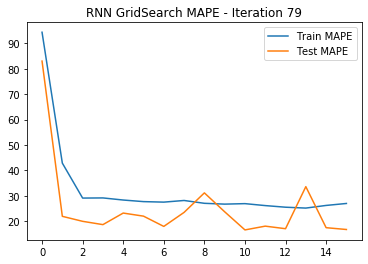

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 80, dtype: float64
Epoch 1/40
69/69 [==============================] - 22s 317ms/step - loss: 8187037696.0000 - mean_absolute_percentage_error: 96.2401 - val_loss: 8302397952.0000 - val_mean_absolute_percentage_error: 99.7106
Epoch 2/40
69/69 [==============================] - 21s 310ms/step - loss: 8358811136.0000 - mean_absolute_percentage_error: 99.7422 - val_loss: 8234069504.0000 - val_mean_absolute_percentage_error: 99.2685
Epoch 3/40
69/69 [==============================] - 21s 310ms/step - loss: 7979014144.0000 - mean_absolute_percentage_error: 97.2164 - val_loss: 8331522048.0000 - val_mean_absolute_percentage_error: 99.8962
Epoch 4/40
69/69 [==========================

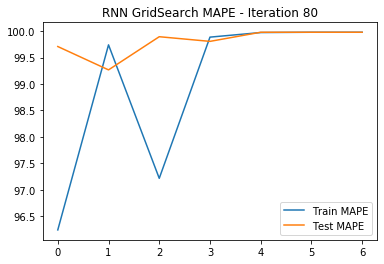

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 81, dtype: float64
Epoch 1/40
69/69 [==============================] - 22s 316ms/step - loss: 7043173888.0000 - mean_absolute_percentage_error: 88.8313 - val_loss: 6893740032.0000 - val_mean_absolute_percentage_error: 90.3821
Epoch 2/40
69/69 [==============================] - 21s 303ms/step - loss: 3585572352.0000 - mean_absolute_percentage_error: 56.3593 - val_loss: 1831879168.0000 - val_mean_absolute_percentage_error: 44.6223
Epoch 3/40
69/69 [==============================] - 21s 301ms/step - loss: 1745572224.0000 - mean_absolute_percentage_error: 37.4028 - val_loss: 1270164736.0000 - val_mean_absolute_percentage_error: 36.4424
Epoch 4/40
69/69 [==========================

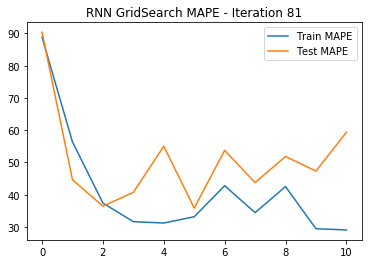

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 82, dtype: float64
Epoch 1/40
69/69 [==============================] - 21s 308ms/step - loss: 4032301824.0000 - mean_absolute_percentage_error: 59.2802 - val_loss: 940813504.0000 - val_mean_absolute_percentage_error: 27.8188
Epoch 2/40
69/69 [==============================] - 21s 301ms/step - loss: 649109568.0000 - mean_absolute_percentage_error: 22.3542 - val_loss: 583901504.0000 - val_mean_absolute_percentage_error: 22.9329
Epoch 3/40
69/69 [==============================] - 20s 296ms/step - loss: 363945216.0000 - mean_absolute_percentage_error: 16.2828 - val_loss: 316266464.0000 - val_mean_absolute_percentage_error: 14.9778
Epoch 4/40
69/69 [==============================]

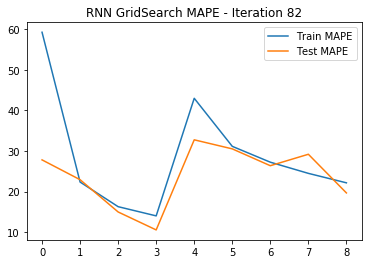

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 83, dtype: float64
Epoch 1/40
69/69 [==============================] - 20s 283ms/step - loss: 8076758528.0000 - mean_absolute_percentage_error: 97.2233 - val_loss: 5169392640.0000 - val_mean_absolute_percentage_error: 76.9976
Epoch 2/40
69/69 [==============================] - 20s 283ms/step - loss: 2228835328.0000 - mean_absolute_percentage_error: 42.4494 - val_loss: 731364224.0000 - val_mean_absolute_percentage_error: 23.7399
Epoch 3/40
69/69 [==============================] - 19s 282ms/step - loss: 1041093120.0000 - mean_absolute_percentage_error: 28.7865 - val_loss: 1786205824.0000 - val_mean_absolute_percentage_error: 43.2709
Epoch 4/40
69/69 [===========================

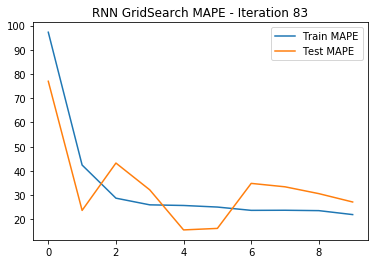

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 84, dtype: float64
Epoch 1/40
69/69 [==============================] - 26s 372ms/step - loss: 7122138624.0000 - mean_absolute_percentage_error: 90.1611 - val_loss: 603104064.0000 - val_mean_absolute_percentage_error: 20.3525
Epoch 2/40
69/69 [==============================] - 25s 365ms/step - loss: 500052416.0000 - mean_absolute_percentage_error: 19.8592 - val_loss: 364397504.0000 - val_mean_absolute_percentage_error: 16.2622
Epoch 3/40
69/69 [==============================] - 25s 367ms/step - loss: 382100672.0000 - mean_absolute_percentage_error: 17.1732 - val_loss: 359116864.0000 - val_mean_absolute_percentage_error: 16.1852
Epoch 4/40
69/69 [==============================]

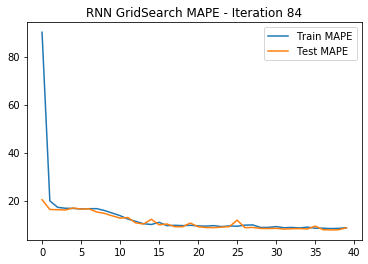

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 85, dtype: float64
Epoch 1/40
69/69 [==============================] - 24s 348ms/step - loss: 8400139264.0000 - mean_absolute_percentage_error: 97.8458 - val_loss: 8329518080.0000 - val_mean_absolute_percentage_error: 99.8830
Epoch 2/40
69/69 [==============================] - 24s 342ms/step - loss: 8366040576.0000 - mean_absolute_percentage_error: 99.7894 - val_loss: 8327458304.0000 - val_mean_absolute_percentage_error: 99.8699
Epoch 3/40
69/69 [==============================] - 24s 341ms/step - loss: 8351271424.0000 - mean_absolute_percentage_error: 99.6914 - val_loss: 8311111168.0000 - val_mean_absolute_percentage_error: 99.7656
Epoch 4/40
69/69 [==========================

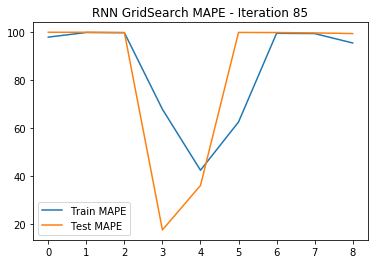

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 86, dtype: float64
Epoch 1/40
69/69 [==============================] - 24s 349ms/step - loss: 8172221952.0000 - mean_absolute_percentage_error: 98.5845 - val_loss: 8279723008.0000 - val_mean_absolute_percentage_error: 99.5631
Epoch 2/40
69/69 [==============================] - 24s 345ms/step - loss: 8343406080.0000 - mean_absolute_percentage_error: 99.6413 - val_loss: 8130637312.0000 - val_mean_absolute_percentage_error: 98.5897
Epoch 3/40
69/69 [==============================] - 24s 344ms/step - loss: 3872418816.0000 - mean_absolute_percentage_error: 56.8119 - val_loss: 862411968.0000 - val_mean_absolute_percentage_error: 24.3189
Epoch 4/40
69/69 [===========================

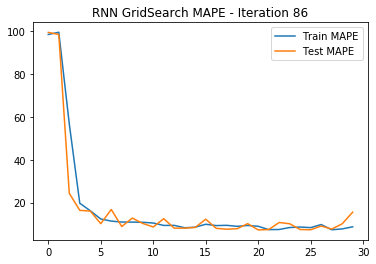

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 87, dtype: float64
Epoch 1/40
69/69 [==============================] - 24s 343ms/step - loss: 6442328576.0000 - mean_absolute_percentage_error: 83.8884 - val_loss: 6664699904.0000 - val_mean_absolute_percentage_error: 88.5419
Epoch 2/40
69/69 [==============================] - 23s 338ms/step - loss: 91694350336.0000 - mean_absolute_percentage_error: 153.4068 - val_loss: 4398412288.0000 - val_mean_absolute_percentage_error: 70.5162
Epoch 3/40
69/69 [==============================] - 23s 337ms/step - loss: 2916002304.0000 - mean_absolute_percentage_error: 50.1745 - val_loss: 3903663872.0000 - val_mean_absolute_percentage_error: 65.9504
Epoch 4/40
69/69 [========================

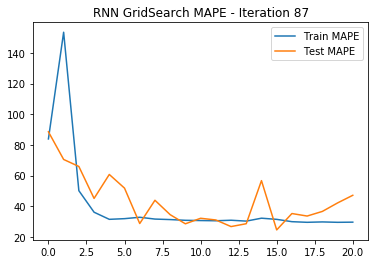

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 88, dtype: float64
Epoch 1/40
69/69 [==============================] - 24s 346ms/step - loss: 8399369216.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 8347869184.0000 - val_mean_absolute_percentage_error: 99.9999
Epoch 2/40
69/69 [==============================] - 24s 343ms/step - loss: 8399354880.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 8347856896.0000 - val_mean_absolute_percentage_error: 99.9998
Epoch 3/40
69/69 [==============================] - 24s 345ms/step - loss: 8399343616.0000 - mean_absolute_percentage_error: 99.9998 - val_loss: 8347846144.0000 - val_mean_absolute_percentage_error: 99.9998
Epoch 4/40
69/69 [========================

Epoch 39/40
69/69 [==============================] - 23s 336ms/step - loss: 8398897664.0000 - mean_absolute_percentage_error: 99.9970 - val_loss: 8347400704.0000 - val_mean_absolute_percentage_error: 99.9969
Epoch 40/40
69/69 [==============================] - 23s 336ms/step - loss: 8398885376.0000 - mean_absolute_percentage_error: 99.9969 - val_loss: 8347387392.0000 - val_mean_absolute_percentage_error: 99.9968


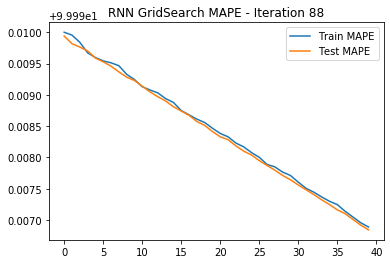

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 89, dtype: float64
Epoch 1/40
69/69 [==============================] - 27s 397ms/step - loss: 6477380096.0000 - mean_absolute_percentage_error: 84.7519 - val_loss: 6757236224.0000 - val_mean_absolute_percentage_error: 89.3962
Epoch 2/40
69/69 [==============================] - 27s 393ms/step - loss: 2619341312.0000 - mean_absolute_percentage_error: 48.6702 - val_loss: 1582519552.0000 - val_mean_absolute_percentage_error: 36.5583
Epoch 3/40
69/69 [==============================] - 27s 388ms/step - loss: 1561098496.0000 - mean_absolute_percentage_error: 35.5785 - val_loss: 2179939584.0000 - val_mean_absolute_percentage_error: 47.7737
Epoch 4/40
69/69 [==========================

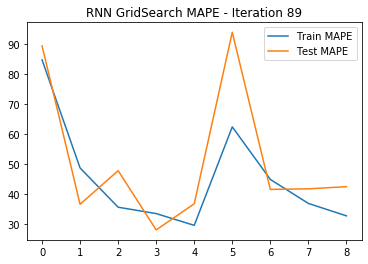

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 90, dtype: float64
Epoch 1/40
69/69 [==============================] - 27s 390ms/step - loss: 7326356480.0000 - mean_absolute_percentage_error: 90.0380 - val_loss: 8332436480.0000 - val_mean_absolute_percentage_error: 99.9014
Epoch 2/40
69/69 [==============================] - 26s 380ms/step - loss: 8391393792.0000 - mean_absolute_percentage_error: 99.9497 - val_loss: 8340551168.0000 - val_mean_absolute_percentage_error: 99.9533
Epoch 3/40
69/69 [==============================] - 26s 379ms/step - loss: 8347450368.0000 - mean_absolute_percentage_error: 99.6787 - val_loss: 8208420352.0000 - val_mean_absolute_percentage_error: 99.1096
Epoch 4/40
69/69 [==========================

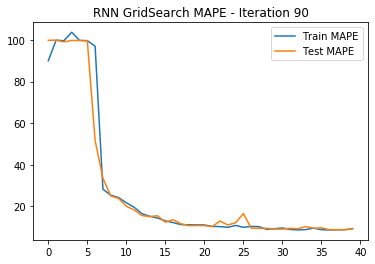

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 91, dtype: float64
Epoch 1/40
69/69 [==============================] - 26s 383ms/step - loss: 6141987328.0000 - mean_absolute_percentage_error: 81.1577 - val_loss: 750562368.0000 - val_mean_absolute_percentage_error: 23.6047
Epoch 2/40
69/69 [==============================] - 26s 376ms/step - loss: 1855907200.0000 - mean_absolute_percentage_error: 38.5845 - val_loss: 1005981568.0000 - val_mean_absolute_percentage_error: 28.5946
Epoch 3/40
69/69 [==============================] - 26s 375ms/step - loss: 1863706624.0000 - mean_absolute_percentage_error: 38.6512 - val_loss: 1042038080.0000 - val_mean_absolute_percentage_error: 29.7798
Epoch 4/40
69/69 [===========================

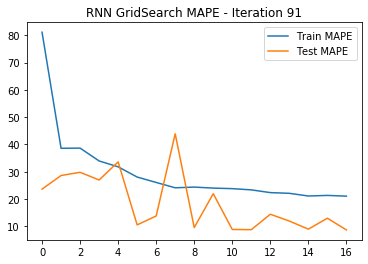

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 92, dtype: float64
Epoch 1/40
69/69 [==============================] - 28s 401ms/step - loss: 6519087616.0000 - mean_absolute_percentage_error: 84.3197 - val_loss: 3198714880.0000 - val_mean_absolute_percentage_error: 59.0194
Epoch 2/40
69/69 [==============================] - 27s 393ms/step - loss: 8045573120.0000 - mean_absolute_percentage_error: 97.6567 - val_loss: 7814072320.0000 - val_mean_absolute_percentage_error: 96.5630
Epoch 3/40
69/69 [==============================] - 27s 395ms/step - loss: 7473112064.0000 - mean_absolute_percentage_error: 93.9040 - val_loss: 6983886848.0000 - val_mean_absolute_percentage_error: 90.9736
Epoch 4/40
69/69 [==========================

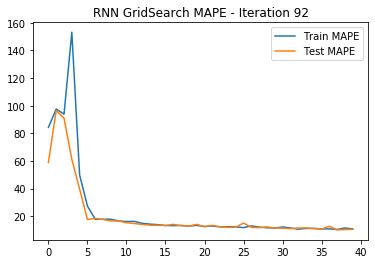

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 93, dtype: float64
Epoch 1/40
69/69 [==============================] - 28s 411ms/step - loss: 8038772224.0000 - mean_absolute_percentage_error: 97.4869 - val_loss: 8021491200.0000 - val_mean_absolute_percentage_error: 97.9081
Epoch 2/40
69/69 [==============================] - 28s 405ms/step - loss: 4106026240.0000 - mean_absolute_percentage_error: 62.4135 - val_loss: 709492480.0000 - val_mean_absolute_percentage_error: 22.8602
Epoch 3/40
69/69 [==============================] - 28s 403ms/step - loss: 1237453568.0000 - mean_absolute_percentage_error: 31.5975 - val_loss: 1221077504.0000 - val_mean_absolute_percentage_error: 31.8085
Epoch 4/40
69/69 [===========================

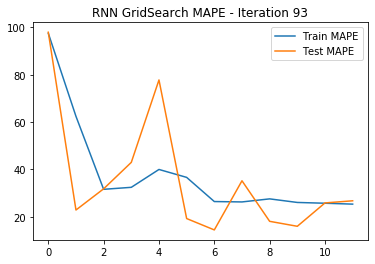

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 94, dtype: float64
Epoch 1/40
69/69 [==============================] - 32s 459ms/step - loss: 4422904320.0000 - mean_absolute_percentage_error: 64.2812 - val_loss: 1912284288.0000 - val_mean_absolute_percentage_error: 39.6308
Epoch 2/40
69/69 [==============================] - 31s 451ms/step - loss: 20638902272.0000 - mean_absolute_percentage_error: 73.5077 - val_loss: 1536876160.0000 - val_mean_absolute_percentage_error: 35.9051
Epoch 3/40
69/69 [==============================] - 31s 453ms/step - loss: 1439547520.0000 - mean_absolute_percentage_error: 34.6128 - val_loss: 1332299520.0000 - val_mean_absolute_percentage_error: 33.4331
Epoch 4/40
69/69 [=========================

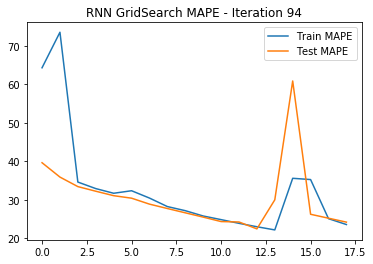

seq_length              48.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 95, dtype: float64
Epoch 1/40
69/69 [==============================] - 31s 446ms/step - loss: 6506754560.0000 - mean_absolute_percentage_error: 84.3605 - val_loss: 6935245312.0000 - val_mean_absolute_percentage_error: 90.4811
Epoch 2/40
69/69 [==============================] - 30s 437ms/step - loss: 5998596608.0000 - mean_absolute_percentage_error: 78.5466 - val_loss: 6683407872.0000 - val_mean_absolute_percentage_error: 88.9464
Epoch 3/40
69/69 [==============================] - 30s 437ms/step - loss: 2218503424.0000 - mean_absolute_percentage_error: 43.0875 - val_loss: 2648114688.0000 - val_mean_absolute_percentage_error: 53.4996
Epoch 4/40
69/69 [==========================

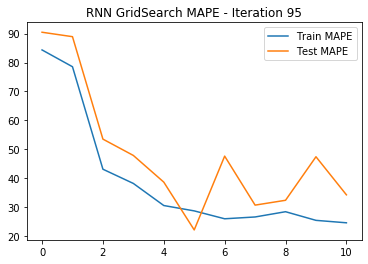

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 96, dtype: float64
Epoch 1/40
35/35 [==============================] - 13s 363ms/step - loss: 8393469440.0000 - mean_absolute_percentage_error: 99.9590 - val_loss: 8262953472.0000 - val_mean_absolute_percentage_error: 99.4535
Epoch 2/40
35/35 [==============================] - 12s 349ms/step - loss: 8354640896.0000 - mean_absolute_percentage_error: 99.7167 - val_loss: 8290174464.0000 - val_mean_absolute_percentage_error: 99.6298
Epoch 3/40
35/35 [==============================] - 12s 350ms/step - loss: 7580727808.0000 - mean_absolute_percentage_error: 92.6776 - val_loss: 8246385664.0000 - val_mean_absolute_percentage_error: 99.3536
Epoch 4/40
35/35 [==========================

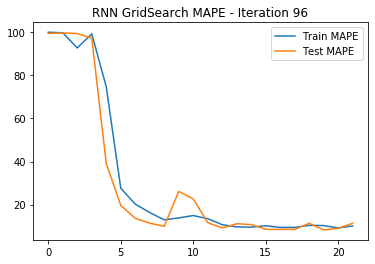

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 97, dtype: float64
Epoch 1/40
35/35 [==============================] - 12s 357ms/step - loss: 8398996992.0000 - mean_absolute_percentage_error: 99.9975 - val_loss: 8346210816.0000 - val_mean_absolute_percentage_error: 99.9894
Epoch 2/40
35/35 [==============================] - 12s 343ms/step - loss: 8186555392.0000 - mean_absolute_percentage_error: 98.6033 - val_loss: 8155422208.0000 - val_mean_absolute_percentage_error: 98.7636
Epoch 3/40
35/35 [==============================] - 12s 342ms/step - loss: 4083715840.0000 - mean_absolute_percentage_error: 62.7233 - val_loss: 2298391296.0000 - val_mean_absolute_percentage_error: 45.8826
Epoch 4/40
35/35 [==========================

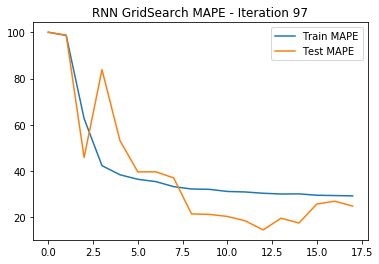

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 98, dtype: float64
Epoch 1/40
35/35 [==============================] - 14s 400ms/step - loss: 8399195648.0000 - mean_absolute_percentage_error: 99.9988 - val_loss: 8346198016.0000 - val_mean_absolute_percentage_error: 99.9893
Epoch 2/40
35/35 [==============================] - 13s 385ms/step - loss: 8288997888.0000 - mean_absolute_percentage_error: 99.2818 - val_loss: 8239307264.0000 - val_mean_absolute_percentage_error: 99.3038
Epoch 3/40
35/35 [==============================] - 13s 385ms/step - loss: 6554468864.0000 - mean_absolute_percentage_error: 87.1975 - val_loss: 7236549632.0000 - val_mean_absolute_percentage_error: 92.6649
Epoch 4/40
35/35 [==========================

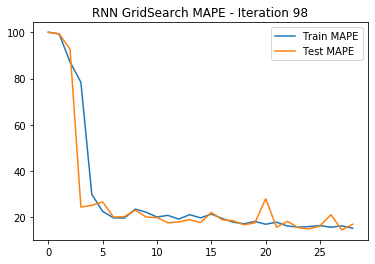

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 99, dtype: float64
Epoch 1/40
35/35 [==============================] - 15s 438ms/step - loss: 8397458432.0000 - mean_absolute_percentage_error: 99.9865 - val_loss: 8332222464.0000 - val_mean_absolute_percentage_error: 99.8998
Epoch 2/40
35/35 [==============================] - 15s 423ms/step - loss: 7576939008.0000 - mean_absolute_percentage_error: 93.6881 - val_loss: 992515904.0000 - val_mean_absolute_percentage_error: 27.3570
Epoch 3/40
35/35 [==============================] - 15s 422ms/step - loss: 3229876736.0000 - mean_absolute_percentage_error: 51.4807 - val_loss: 6168120832.0000 - val_mean_absolute_percentage_error: 84.7696
Epoch 4/40
35/35 [===========================

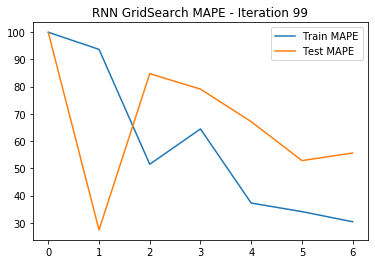

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 100, dtype: float64
Epoch 1/40
35/35 [==============================] - 16s 452ms/step - loss: 8398806528.0000 - mean_absolute_percentage_error: 99.9962 - val_loss: 8340068352.0000 - val_mean_absolute_percentage_error: 99.9501
Epoch 2/40
35/35 [==============================] - 15s 438ms/step - loss: 8188855296.0000 - mean_absolute_percentage_error: 98.6763 - val_loss: 8229809152.0000 - val_mean_absolute_percentage_error: 99.2440
Epoch 3/40
35/35 [==============================] - 15s 440ms/step - loss: 8175225856.0000 - mean_absolute_percentage_error: 98.5986 - val_loss: 7828835328.0000 - val_mean_absolute_percentage_error: 96.6361
Epoch 4/40
35/35 [=========================

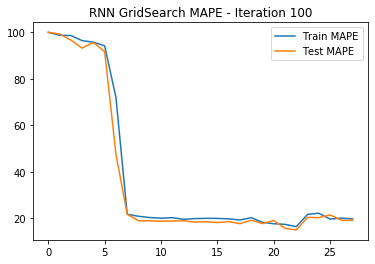

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 101, dtype: float64
Epoch 1/40
35/35 [==============================] - 16s 445ms/step - loss: 8396312064.0000 - mean_absolute_percentage_error: 99.9784 - val_loss: 8315174400.0000 - val_mean_absolute_percentage_error: 99.7898
Epoch 2/40
35/35 [==============================] - 15s 431ms/step - loss: 5187028480.0000 - mean_absolute_percentage_error: 71.2721 - val_loss: 6963401216.0000 - val_mean_absolute_percentage_error: 90.7590
Epoch 3/40
35/35 [==============================] - 15s 431ms/step - loss: 2049198592.0000 - mean_absolute_percentage_error: 41.7685 - val_loss: 1154849792.0000 - val_mean_absolute_percentage_error: 30.0505
Epoch 4/40
35/35 [=========================

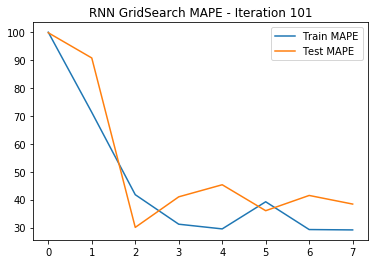

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 102, dtype: float64
Epoch 1/40
35/35 [==============================] - 16s 463ms/step - loss: 8398673408.0000 - mean_absolute_percentage_error: 99.9953 - val_loss: 8338862080.0000 - val_mean_absolute_percentage_error: 99.9428
Epoch 2/40
35/35 [==============================] - 16s 446ms/step - loss: 7821130240.0000 - mean_absolute_percentage_error: 96.1164 - val_loss: 8020029952.0000 - val_mean_absolute_percentage_error: 97.8850
Epoch 3/40
35/35 [==============================] - 16s 448ms/step - loss: 8019647488.0000 - mean_absolute_percentage_error: 97.5735 - val_loss: 7888824320.0000 - val_mean_absolute_percentage_error: 97.0017
Epoch 4/40
35/35 [=========================

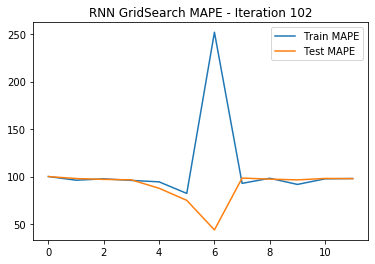

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 103, dtype: float64
Epoch 1/40
35/35 [==============================] - 16s 468ms/step - loss: 8399330816.0000 - mean_absolute_percentage_error: 99.9997 - val_loss: 8347637760.0000 - val_mean_absolute_percentage_error: 99.9984
Epoch 2/40
35/35 [==============================] - 16s 449ms/step - loss: 8360754688.0000 - mean_absolute_percentage_error: 99.7514 - val_loss: 8285950976.0000 - val_mean_absolute_percentage_error: 99.6010
Epoch 3/40
35/35 [==============================] - 16s 450ms/step - loss: 8110674944.0000 - mean_absolute_percentage_error: 97.9570 - val_loss: 8327776768.0000 - val_mean_absolute_percentage_error: 99.8709
Epoch 4/40
35/35 [=========================

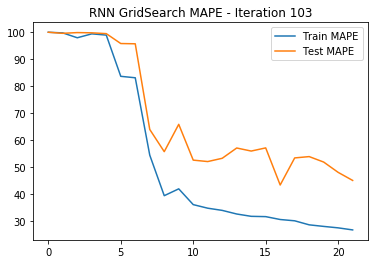

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 104, dtype: float64
Epoch 1/40
35/35 [==============================] - 17s 479ms/step - loss: 8398269952.0000 - mean_absolute_percentage_error: 99.9925 - val_loss: 8332590080.0000 - val_mean_absolute_percentage_error: 99.9027
Epoch 2/40
35/35 [==============================] - 16s 458ms/step - loss: 5143985152.0000 - mean_absolute_percentage_error: 70.2838 - val_loss: 2395287808.0000 - val_mean_absolute_percentage_error: 45.4036
Epoch 3/40
35/35 [==============================] - 16s 461ms/step - loss: 3207837184.0000 - mean_absolute_percentage_error: 53.6603 - val_loss: 1202185472.0000 - val_mean_absolute_percentage_error: 31.1086
Epoch 4/40
35/35 [=========================

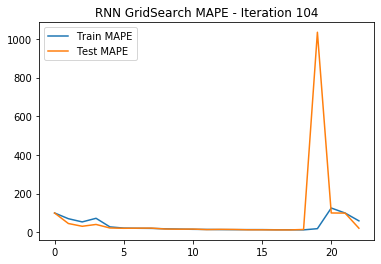

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 105, dtype: float64
Epoch 1/40
35/35 [==============================] - 17s 474ms/step - loss: 8389789184.0000 - mean_absolute_percentage_error: 99.9340 - val_loss: 7999926784.0000 - val_mean_absolute_percentage_error: 97.7754
Epoch 2/40
35/35 [==============================] - 16s 458ms/step - loss: 6970472448.0000 - mean_absolute_percentage_error: 89.1154 - val_loss: 7701086720.0000 - val_mean_absolute_percentage_error: 95.8020
Epoch 3/40
35/35 [==============================] - 16s 460ms/step - loss: 4144226816.0000 - mean_absolute_percentage_error: 63.5720 - val_loss: 2764679424.0000 - val_mean_absolute_percentage_error: 54.1184
Epoch 4/40
35/35 [=========================

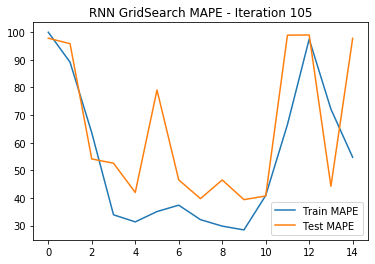

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 106, dtype: float64
Epoch 1/40
35/35 [==============================] - 18s 504ms/step - loss: 8396524032.0000 - mean_absolute_percentage_error: 99.9800 - val_loss: 8306144256.0000 - val_mean_absolute_percentage_error: 99.7319
Epoch 2/40
35/35 [==============================] - 17s 484ms/step - loss: 7613551104.0000 - mean_absolute_percentage_error: 70.1033 - val_loss: 1400008704.0000 - val_mean_absolute_percentage_error: 33.5581
Epoch 3/40
35/35 [==============================] - 17s 490ms/step - loss: 1630710016.0000 - mean_absolute_percentage_error: 36.8367 - val_loss: 1092498560.0000 - val_mean_absolute_percentage_error: 29.9320
Epoch 4/40
35/35 [=========================

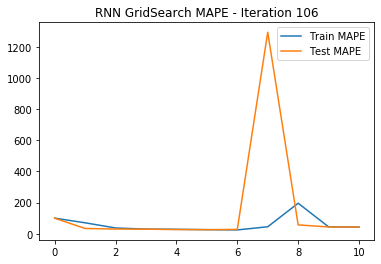

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 107, dtype: float64
Epoch 1/40
35/35 [==============================] - 18s 509ms/step - loss: 8397381632.0000 - mean_absolute_percentage_error: 99.9864 - val_loss: 8331563520.0000 - val_mean_absolute_percentage_error: 99.8961
Epoch 2/40
35/35 [==============================] - 17s 488ms/step - loss: 7162953728.0000 - mean_absolute_percentage_error: 91.4136 - val_loss: 7759090688.0000 - val_mean_absolute_percentage_error: 96.1159
Epoch 3/40
35/35 [==============================] - 17s 482ms/step - loss: 5676199936.0000 - mean_absolute_percentage_error: 80.2830 - val_loss: 3889920512.0000 - val_mean_absolute_percentage_error: 64.6362
Epoch 4/40
35/35 [=========================

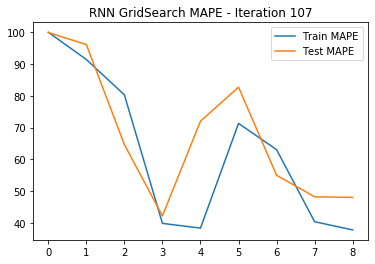

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 108, dtype: float64
Epoch 1/40
35/35 [==============================] - 18s 514ms/step - loss: 8398706688.0000 - mean_absolute_percentage_error: 99.9955 - val_loss: 8339665920.0000 - val_mean_absolute_percentage_error: 99.9479
Epoch 2/40
35/35 [==============================] - 17s 496ms/step - loss: 6181844156416.0000 - mean_absolute_percentage_error: 1087.4058 - val_loss: 7687604535296.0000 - val_mean_absolute_percentage_error: 2959.6091
Epoch 3/40
35/35 [==============================] - 17s 495ms/step - loss: 1157949685760.0000 - mean_absolute_percentage_error: 1105.9017 - val_loss: 249236684800.0000 - val_mean_absolute_percentage_error: 528.0662
Epoch 4/40
35/35 [=======

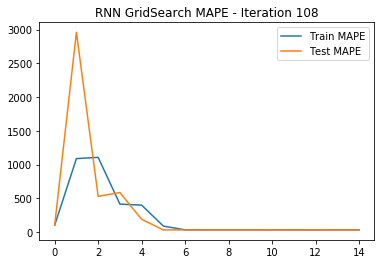

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 109, dtype: float64
Epoch 1/40
35/35 [==============================] - 20s 579ms/step - loss: 8193218560.0000 - mean_absolute_percentage_error: 98.3790 - val_loss: 4604746752.0000 - val_mean_absolute_percentage_error: 71.8737
Epoch 2/40
35/35 [==============================] - 20s 564ms/step - loss: 3663019008.0000 - mean_absolute_percentage_error: 50.0034 - val_loss: 2983071744.0000 - val_mean_absolute_percentage_error: 55.8865
Epoch 3/40
35/35 [==============================] - 20s 560ms/step - loss: 2016011648.0000 - mean_absolute_percentage_error: 41.2312 - val_loss: 1720497408.0000 - val_mean_absolute_percentage_error: 39.5404
Epoch 4/40
35/35 [=========================

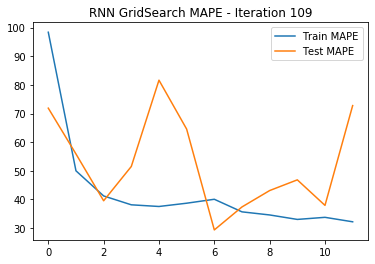

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 110, dtype: float64
Epoch 1/40
35/35 [==============================] - 21s 598ms/step - loss: 8340507136.0000 - mean_absolute_percentage_error: 99.5834 - val_loss: 5441352704.0000 - val_mean_absolute_percentage_error: 78.9881
Epoch 2/40
35/35 [==============================] - 20s 580ms/step - loss: 6640802304.0000 - mean_absolute_percentage_error: 70.9771 - val_loss: 7189505024.0000 - val_mean_absolute_percentage_error: 92.2904
Epoch 3/40
35/35 [==============================] - 20s 574ms/step - loss: 7905724928.0000 - mean_absolute_percentage_error: 96.7746 - val_loss: 7962228224.0000 - val_mean_absolute_percentage_error: 97.5073
Epoch 4/40
35/35 [=========================

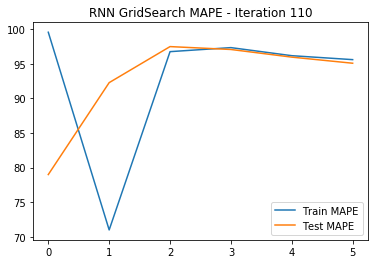

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 111, dtype: float64
Epoch 1/40
35/35 [==============================] - 20s 582ms/step - loss: 8395692544.0000 - mean_absolute_percentage_error: 99.9749 - val_loss: 8316231680.0000 - val_mean_absolute_percentage_error: 99.8000
Epoch 2/40
35/35 [==============================] - 20s 565ms/step - loss: 5962049024.0000 - mean_absolute_percentage_error: 79.9446 - val_loss: 7743855616.0000 - val_mean_absolute_percentage_error: 96.1109
Epoch 3/40
35/35 [==============================] - 20s 561ms/step - loss: 2280176222208.0000 - mean_absolute_percentage_error: 172.9021 - val_loss: 8294358016.0000 - val_mean_absolute_percentage_error: 99.6621
Epoch 4/40
35/35 [=====================

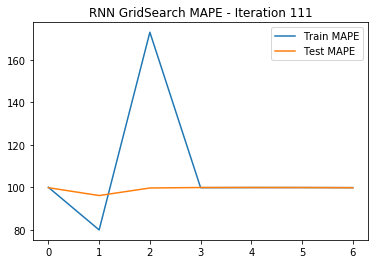

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 112, dtype: float64
Epoch 1/40
35/35 [==============================] - 19s 535ms/step - loss: 8233329664.0000 - mean_absolute_percentage_error: 98.7246 - val_loss: 6578735104.0000 - val_mean_absolute_percentage_error: 87.7210
Epoch 2/40
35/35 [==============================] - 18s 520ms/step - loss: 6613441536.0000 - mean_absolute_percentage_error: 86.5212 - val_loss: 8310192128.0000 - val_mean_absolute_percentage_error: 99.7603
Epoch 3/40
35/35 [==============================] - 18s 520ms/step - loss: 8368776192.0000 - mean_absolute_percentage_error: 99.8061 - val_loss: 8319136768.0000 - val_mean_absolute_percentage_error: 99.8174
Epoch 4/40
35/35 [=========================

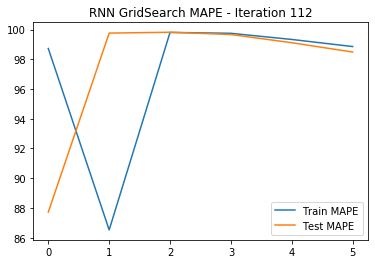

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 113, dtype: float64
Epoch 1/40
35/35 [==============================] - 18s 526ms/step - loss: 8303314944.0000 - mean_absolute_percentage_error: 99.3810 - val_loss: 8292983808.0000 - val_mean_absolute_percentage_error: 99.6484
Epoch 2/40
35/35 [==============================] - 18s 511ms/step - loss: 4679870464.0000 - mean_absolute_percentage_error: 65.8376 - val_loss: 4214460672.0000 - val_mean_absolute_percentage_error: 69.1145
Epoch 3/40
35/35 [==============================] - 18s 512ms/step - loss: 1828004352.0000 - mean_absolute_percentage_error: 38.7762 - val_loss: 797691648.0000 - val_mean_absolute_percentage_error: 25.9461
Epoch 4/40
35/35 [==========================

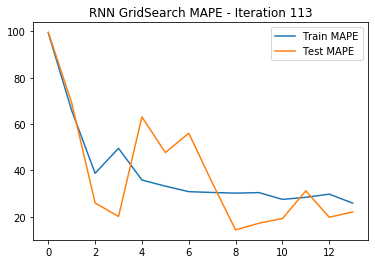

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 114, dtype: float64
Epoch 1/40
35/35 [==============================] - 20s 581ms/step - loss: 7414897664.0000 - mean_absolute_percentage_error: 90.0883 - val_loss: 3918033408.0000 - val_mean_absolute_percentage_error: 65.7620
Epoch 2/40
35/35 [==============================] - 20s 573ms/step - loss: 7702138368.0000 - mean_absolute_percentage_error: 95.1899 - val_loss: 7469305344.0000 - val_mean_absolute_percentage_error: 94.1068
Epoch 3/40
35/35 [==============================] - 20s 580ms/step - loss: 4153839360.0000 - mean_absolute_percentage_error: 63.8160 - val_loss: 4472303104.0000 - val_mean_absolute_percentage_error: 68.5841
Epoch 4/40
35/35 [=========================

Epoch 39/40
35/35 [==============================] - 20s 584ms/step - loss: 934823168.0000 - mean_absolute_percentage_error: 26.6910 - val_loss: 1237552640.0000 - val_mean_absolute_percentage_error: 32.2102
Epoch 40/40
35/35 [==============================] - 20s 584ms/step - loss: 879039360.0000 - mean_absolute_percentage_error: 26.1384 - val_loss: 830458624.0000 - val_mean_absolute_percentage_error: 25.6106


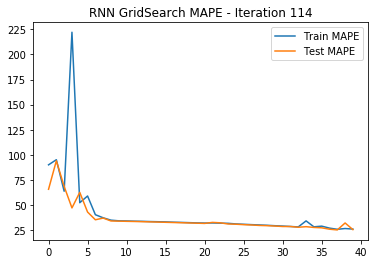

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 115, dtype: float64
Epoch 1/40
35/35 [==============================] - 24s 672ms/step - loss: 8364665344.0000 - mean_absolute_percentage_error: 99.7556 - val_loss: 7950923776.0000 - val_mean_absolute_percentage_error: 97.4411
Epoch 2/40
35/35 [==============================] - 23s 656ms/step - loss: 25787428864.0000 - mean_absolute_percentage_error: 99.7285 - val_loss: 8202674688.0000 - val_mean_absolute_percentage_error: 99.0521
Epoch 3/40
35/35 [==============================] - 23s 653ms/step - loss: 8334706176.0000 - mean_absolute_percentage_error: 99.5693 - val_loss: 8339208704.0000 - val_mean_absolute_percentage_error: 99.9445
Epoch 4/40
35/35 [========================

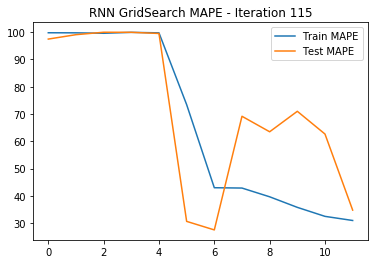

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 116, dtype: float64
Epoch 1/40
35/35 [==============================] - 23s 662ms/step - loss: 8379952640.0000 - mean_absolute_percentage_error: 99.8640 - val_loss: 8037699072.0000 - val_mean_absolute_percentage_error: 98.0077
Epoch 2/40
35/35 [==============================] - 23s 655ms/step - loss: 4675946496.0000 - mean_absolute_percentage_error: 65.3413 - val_loss: 2347332864.0000 - val_mean_absolute_percentage_error: 48.6016
Epoch 3/40
35/35 [==============================] - 23s 658ms/step - loss: 1150130048.0000 - mean_absolute_percentage_error: 29.6733 - val_loss: 280216640.0000 - val_mean_absolute_percentage_error: 15.5465
Epoch 4/40
35/35 [==========================

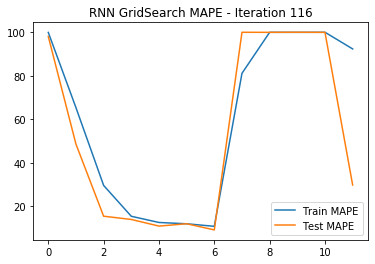

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 117, dtype: float64
Epoch 1/40
35/35 [==============================] - 23s 665ms/step - loss: 8369935360.0000 - mean_absolute_percentage_error: 99.8110 - val_loss: 8313476608.0000 - val_mean_absolute_percentage_error: 99.7793
Epoch 2/40
35/35 [==============================] - 23s 653ms/step - loss: 75193581568.0000 - mean_absolute_percentage_error: 184.2514 - val_loss: 12321490944.0000 - val_mean_absolute_percentage_error: 122.8272
Epoch 3/40
35/35 [==============================] - 23s 654ms/step - loss: 8163103744.0000 - mean_absolute_percentage_error: 95.5599 - val_loss: 8267884032.0000 - val_mean_absolute_percentage_error: 99.4630
Epoch 4/40
35/35 [=====================

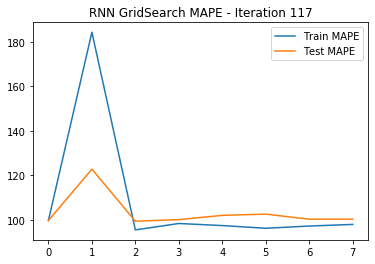

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 118, dtype: float64
Epoch 1/40
35/35 [==============================] - 24s 683ms/step - loss: 8395661824.0000 - mean_absolute_percentage_error: 99.9737 - val_loss: 7708443136.0000 - val_mean_absolute_percentage_error: 95.8486
Epoch 2/40
35/35 [==============================] - 23s 669ms/step - loss: 8038079488.0000 - mean_absolute_percentage_error: 97.6749 - val_loss: 7695341568.0000 - val_mean_absolute_percentage_error: 95.7374
Epoch 3/40
35/35 [==============================] - 23s 670ms/step - loss: 21034891264.0000 - mean_absolute_percentage_error: 128.0195 - val_loss: 53058510848.0000 - val_mean_absolute_percentage_error: 245.8054
Epoch 4/40
35/35 [=====================

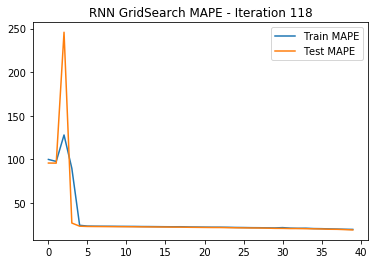

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 119, dtype: float64
Epoch 1/40
35/35 [==============================] - 23s 668ms/step - loss: 8399148544.0000 - mean_absolute_percentage_error: 99.9985 - val_loss: 8345043968.0000 - val_mean_absolute_percentage_error: 99.9819
Epoch 2/40
35/35 [==============================] - 23s 651ms/step - loss: 8822079488.0000 - mean_absolute_percentage_error: 95.7355 - val_loss: 8329540096.0000 - val_mean_absolute_percentage_error: 99.8835
Epoch 3/40
35/35 [==============================] - 23s 649ms/step - loss: 8382442496.0000 - mean_absolute_percentage_error: 99.8921 - val_loss: 8339000320.0000 - val_mean_absolute_percentage_error: 99.9436
Epoch 4/40
35/35 [=========================

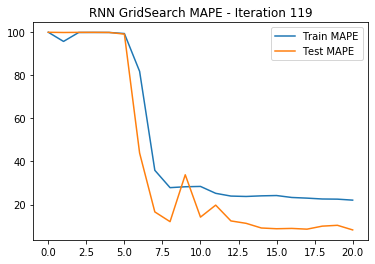

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 120, dtype: float64
Epoch 1/40
35/35 [==============================] - 25s 702ms/step - loss: 15311873024.0000 - mean_absolute_percentage_error: 110.9028 - val_loss: 1535781504.0000 - val_mean_absolute_percentage_error: 33.5860
Epoch 2/40
35/35 [==============================] - 24s 687ms/step - loss: 1933629312.0000 - mean_absolute_percentage_error: 39.8752 - val_loss: 696305984.0000 - val_mean_absolute_percentage_error: 24.3394
Epoch 3/40
35/35 [==============================] - 24s 689ms/step - loss: 748291840.0000 - mean_absolute_percentage_error: 24.1674 - val_loss: 501065344.0000 - val_mean_absolute_percentage_error: 19.7114
Epoch 4/40
35/35 [==========================

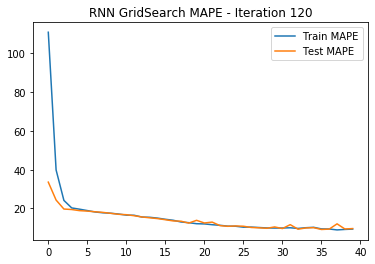

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 121, dtype: float64
Epoch 1/40
35/35 [==============================] - 25s 702ms/step - loss: 8346370048.0000 - mean_absolute_percentage_error: 99.5943 - val_loss: 2908001792.0000 - val_mean_absolute_percentage_error: 54.9185
Epoch 2/40
35/35 [==============================] - 24s 688ms/step - loss: 3865006080.0000 - mean_absolute_percentage_error: 59.9122 - val_loss: 3998392576.0000 - val_mean_absolute_percentage_error: 67.5208
Epoch 3/40
35/35 [==============================] - 24s 680ms/step - loss: 2505751808.0000 - mean_absolute_percentage_error: 43.4759 - val_loss: 2748028672.0000 - val_mean_absolute_percentage_error: 55.3795
Epoch 4/40
35/35 [=========================

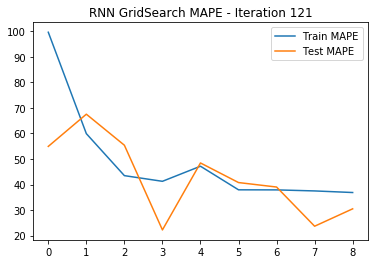

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 122, dtype: float64
Epoch 1/40
35/35 [==============================] - 26s 731ms/step - loss: 8398808576.0000 - mean_absolute_percentage_error: 99.9962 - val_loss: 8340112384.0000 - val_mean_absolute_percentage_error: 99.9503
Epoch 2/40
35/35 [==============================] - 25s 714ms/step - loss: 8137345536.0000 - mean_absolute_percentage_error: 94.6658 - val_loss: 8296207360.0000 - val_mean_absolute_percentage_error: 99.6704
Epoch 3/40
35/35 [==============================] - 25s 716ms/step - loss: 8356357632.0000 - mean_absolute_percentage_error: 99.7296 - val_loss: 8280536576.0000 - val_mean_absolute_percentage_error: 99.5694
Epoch 4/40
35/35 [=========================

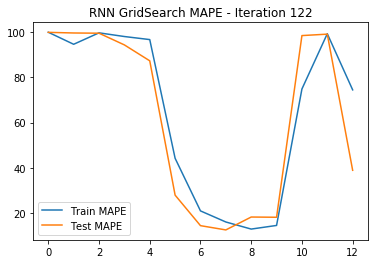

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 123, dtype: float64
Epoch 1/40
35/35 [==============================] - 25s 722ms/step - loss: 7268848128.0000 - mean_absolute_percentage_error: 89.2684 - val_loss: 4149080064.0000 - val_mean_absolute_percentage_error: 67.7163
Epoch 2/40
35/35 [==============================] - 25s 704ms/step - loss: 3084072960.0000 - mean_absolute_percentage_error: 51.5164 - val_loss: 1273630720.0000 - val_mean_absolute_percentage_error: 35.0038
Epoch 3/40
35/35 [==============================] - 25s 701ms/step - loss: 2451223808.0000 - mean_absolute_percentage_error: 48.3329 - val_loss: 3925803264.0000 - val_mean_absolute_percentage_error: 67.7498
Epoch 4/40
35/35 [=========================

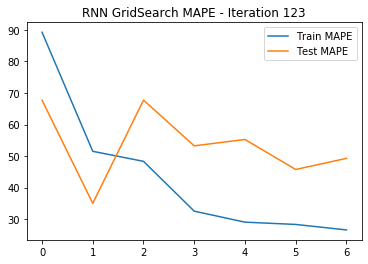

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 124, dtype: float64
Epoch 1/40
35/35 [==============================] - 25s 728ms/step - loss: 7737150464.0000 - mean_absolute_percentage_error: 94.7274 - val_loss: 6625657856.0000 - val_mean_absolute_percentage_error: 88.4124
Epoch 2/40
35/35 [==============================] - 25s 714ms/step - loss: 6328874496.0000 - mean_absolute_percentage_error: 85.5253 - val_loss: 7428787200.0000 - val_mean_absolute_percentage_error: 93.9949
Epoch 3/40
35/35 [==============================] - 25s 711ms/step - loss: 7387202560.0000 - mean_absolute_percentage_error: 93.4296 - val_loss: 7225400320.0000 - val_mean_absolute_percentage_error: 92.6002
Epoch 4/40
35/35 [=========================

35/35 [==============================] - 25s 726ms/step - loss: 701019968.0000 - mean_absolute_percentage_error: 23.6727 - val_loss: 660756160.0000 - val_mean_absolute_percentage_error: 22.9306
Epoch 40/40
35/35 [==============================] - 25s 726ms/step - loss: 701600960.0000 - mean_absolute_percentage_error: 23.8100 - val_loss: 660658432.0000 - val_mean_absolute_percentage_error: 22.9146


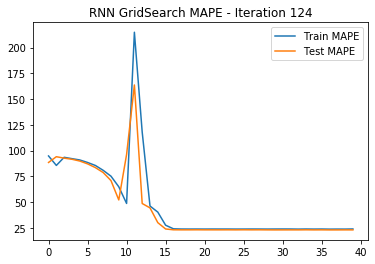

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 125, dtype: float64
Epoch 1/40
35/35 [==============================] - 26s 738ms/step - loss: 8328094208.0000 - mean_absolute_percentage_error: 99.5368 - val_loss: 8165112832.0000 - val_mean_absolute_percentage_error: 98.8323
Epoch 2/40
35/35 [==============================] - 26s 732ms/step - loss: 6450701824.0000 - mean_absolute_percentage_error: 81.1218 - val_loss: 2578073856.0000 - val_mean_absolute_percentage_error: 49.1477
Epoch 3/40
35/35 [==============================] - 26s 730ms/step - loss: 7364055040.0000 - mean_absolute_percentage_error: 85.0892 - val_loss: 8312172032.0000 - val_mean_absolute_percentage_error: 99.7707
Epoch 4/40
35/35 [=========================

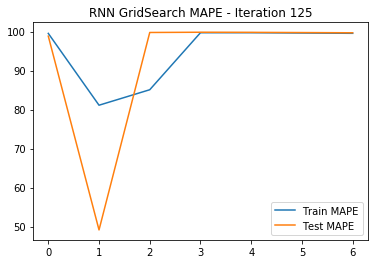

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 126, dtype: float64
Epoch 1/40
35/35 [==============================] - 31s 898ms/step - loss: 8272189952.0000 - mean_absolute_percentage_error: 99.1431 - val_loss: 7810503168.0000 - val_mean_absolute_percentage_error: 96.5283
Epoch 2/40
35/35 [==============================] - 31s 896ms/step - loss: 8222542336.0000 - mean_absolute_percentage_error: 98.8699 - val_loss: 8283729920.0000 - val_mean_absolute_percentage_error: 99.5911
Epoch 3/40
35/35 [==============================] - 31s 894ms/step - loss: 8319774720.0000 - mean_absolute_percentage_error: 99.5001 - val_loss: 8243390464.0000 - val_mean_absolute_percentage_error: 99.3326
Epoch 4/40
35/35 [=========================

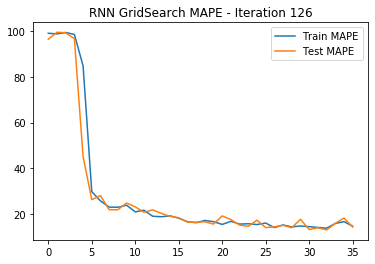

seq_length              48.000
seq_batch_size         512.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 127, dtype: float64
Epoch 1/40
35/35 [==============================] - 31s 891ms/step - loss: 8324465152.0000 - mean_absolute_percentage_error: 99.4797 - val_loss: 8089684480.0000 - val_mean_absolute_percentage_error: 98.3493
Epoch 2/40
35/35 [==============================] - 31s 883ms/step - loss: 17188194304.0000 - mean_absolute_percentage_error: 106.9471 - val_loss: 7831534592.0000 - val_mean_absolute_percentage_error: 96.7050
Epoch 3/40
35/35 [==============================] - 31s 878ms/step - loss: 6440128000.0000 - mean_absolute_percentage_error: 86.7367 - val_loss: 7248124416.0000 - val_mean_absolute_percentage_error: 92.8294
Epoch 4/40
35/35 [=======================

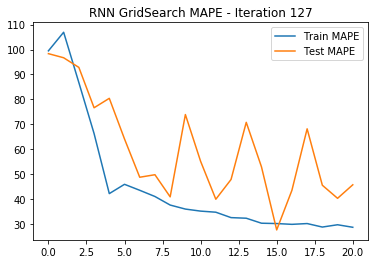

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 128, dtype: float64
Epoch 1/40
68/68 [==============================] - 80s 1s/step - loss: 8322179072.0000 - mean_absolute_percentage_error: 99.5538 - val_loss: 8212958208.0000 - val_mean_absolute_percentage_error: 99.0851
Epoch 2/40
68/68 [==============================] - 80s 1s/step - loss: 8321498112.0000 - mean_absolute_percentage_error: 99.5510 - val_loss: 8230887424.0000 - val_mean_absolute_percentage_error: 99.2058
Epoch 3/40
68/68 [==============================] - 79s 1s/step - loss: 8226527744.0000 - mean_absolute_percentage_error: 98.9390 - val_loss: 8169289728.0000 - val_mean_absolute_percentage_error: 98.8108
Epoch 4/40
68/68 [==============================] - 

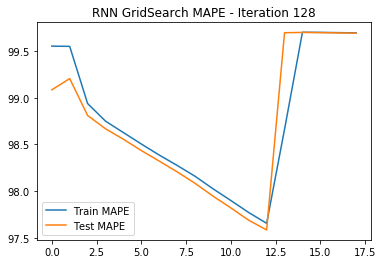

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 129, dtype: float64
Epoch 1/40
68/68 [==============================] - 78s 1s/step - loss: 8506468864.0000 - mean_absolute_percentage_error: 100.0241 - val_loss: 8349675520.0000 - val_mean_absolute_percentage_error: 99.9628
Epoch 2/40
68/68 [==============================] - 77s 1s/step - loss: 12615231488.0000 - mean_absolute_percentage_error: 102.4077 - val_loss: 8352874496.0000 - val_mean_absolute_percentage_error: 99.9833
Epoch 3/40
68/68 [==============================] - 79s 1s/step - loss: 8390328832.0000 - mean_absolute_percentage_error: 99.9841 - val_loss: 8353129472.0000 - val_mean_absolute_percentage_error: 99.9849
Epoch 4/40
68/68 [==============================]

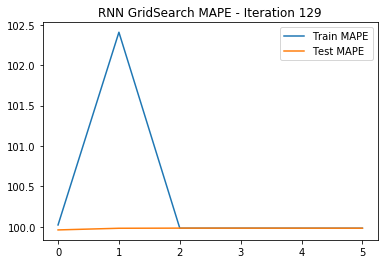

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 130, dtype: float64
Epoch 1/40
68/68 [==============================] - 79s 1s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 2/40
68/68 [==============================] - 78s 1s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 3/40
68/68 [==============================] - 77s 1s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/40
68/68 [==============================] - 78s 1s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 77s 1s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00005: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epoch

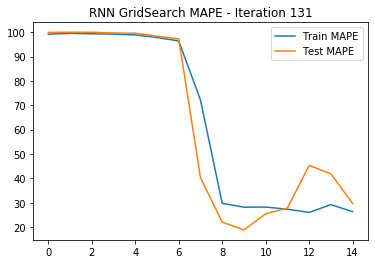

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 132, dtype: float64
Epoch 1/40
68/68 [==============================] - 118s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 2/40
68/68 [==============================] - 118s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 3/40
68/68 [==============================] - 118s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/40
68/68 [==============================] - 118s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 118s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00005: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
e

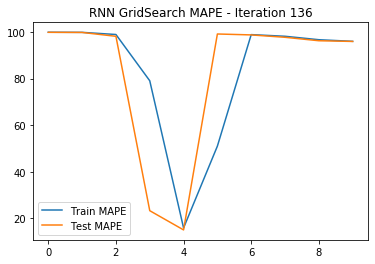

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 137, dtype: float64
Epoch 1/40
68/68 [==============================] - 127s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 2/40
68/68 [==============================] - 126s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 3/40
68/68 [==============================] - 126s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/40
68/68 [==============================] - 128s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 127s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00005: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
e

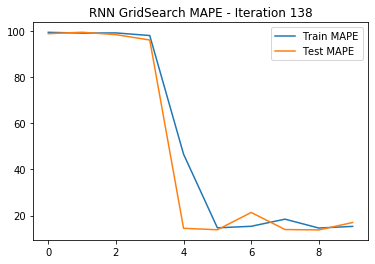

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 139, dtype: float64
Epoch 1/40
68/68 [==============================] - 150s 2s/step - loss: 9779022848.0000 - mean_absolute_percentage_error: 99.1642 - val_loss: 8084726272.0000 - val_mean_absolute_percentage_error: 98.2579
Epoch 2/40
68/68 [==============================] - 148s 2s/step - loss: 8012253184.0000 - mean_absolute_percentage_error: 97.5636 - val_loss: 8162121216.0000 - val_mean_absolute_percentage_error: 98.7550
Epoch 3/40
68/68 [==============================] - 150s 2s/step - loss: 7787002880.0000 - mean_absolute_percentage_error: 95.7176 - val_loss: 8083637760.0000 - val_mean_absolute_percentage_error: 98.2550
Epoch 4/40
68/68 [==============================]

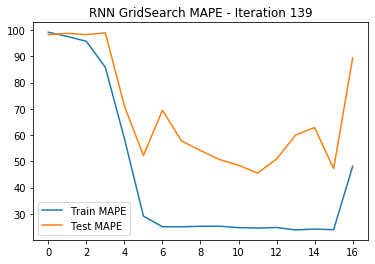

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 140, dtype: float64
Epoch 1/40
68/68 [==============================] - 159s 2s/step - loss: 8162844672.0000 - mean_absolute_percentage_error: 98.5707 - val_loss: 8140616192.0000 - val_mean_absolute_percentage_error: 98.6589
Epoch 2/40
68/68 [==============================] - 158s 2s/step - loss: 8258585600.0000 - mean_absolute_percentage_error: 99.1492 - val_loss: 8221872128.0000 - val_mean_absolute_percentage_error: 99.1517
Epoch 3/40
68/68 [==============================] - 159s 2s/step - loss: 8250272256.0000 - mean_absolute_percentage_error: 99.0961 - val_loss: 8202619392.0000 - val_mean_absolute_percentage_error: 99.0265
Epoch 4/40
68/68 [==============================]

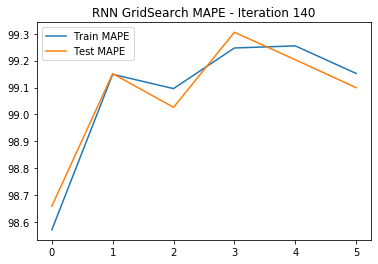

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 141, dtype: float64
Epoch 1/40
68/68 [==============================] - 158s 2s/step - loss: 8314673152.0000 - mean_absolute_percentage_error: 99.5279 - val_loss: 8329062912.0000 - val_mean_absolute_percentage_error: 99.8311
Epoch 2/40
68/68 [==============================] - 158s 2s/step - loss: 8262563328.0000 - mean_absolute_percentage_error: 99.1716 - val_loss: 8284876288.0000 - val_mean_absolute_percentage_error: 99.5497
Epoch 3/40
68/68 [==============================] - 157s 2s/step - loss: 8242024960.0000 - mean_absolute_percentage_error: 99.0426 - val_loss: 8317955584.0000 - val_mean_absolute_percentage_error: 99.7605
Epoch 4/40
68/68 [==============================]

C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 6/40
68/68 [==============================] - 158s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 7/40
68/68 [==============================] - 158s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 8/40
68/68 [==============================] - 157s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 9/40
68/68 [==============================] - 158s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00009: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons       64.000
layer_two_neurons       64.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
e

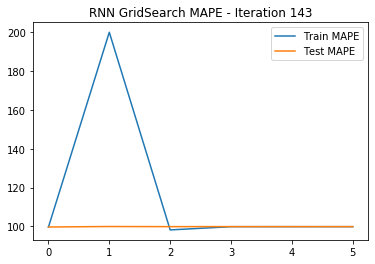

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 144, dtype: float64
Epoch 1/40
68/68 [==============================] - 127s 2s/step - loss: 8012482560.0000 - mean_absolute_percentage_error: 96.3920 - val_loss: 8306842624.0000 - val_mean_absolute_percentage_error: 99.6892
Epoch 2/40
68/68 [==============================] - 127s 2s/step - loss: 8288213504.0000 - mean_absolute_percentage_error: 99.3459 - val_loss: 8156032512.0000 - val_mean_absolute_percentage_error: 98.7225
Epoch 3/40
68/68 [==============================] - 128s 2s/step - loss: 8188249088.0000 - mean_absolute_percentage_error: 98.6904 - val_loss: 8114426368.0000 - val_mean_absolute_percentage_error: 98.4513
Epoch 4/40
68/68 [==============================]

C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 6/40
68/68 [==============================] - 127s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 7/40
68/68 [==============================] - 128s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 8/40
68/68 [==============================] - 128s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 9/40
68/68 [==============================] - 128s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00009: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
e

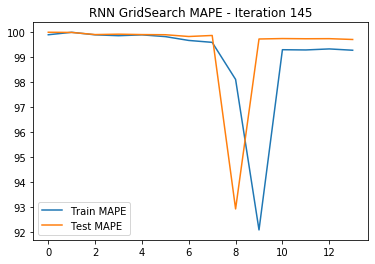

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 146, dtype: float64
Epoch 1/40
68/68 [==============================] - 141s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 2/40
68/68 [==============================] - 140s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 3/40
68/68 [==============================] - 141s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/40
68/68 [==============================] - 141s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 142s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00005: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
e

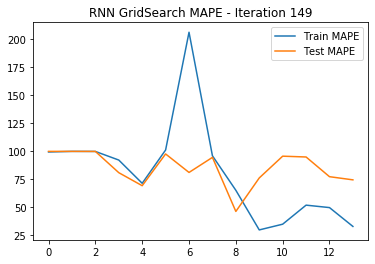

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 150, dtype: float64
Epoch 1/40
68/68 [==============================] - 165s 2s/step - loss: 8370959872.0000 - mean_absolute_percentage_error: 99.8548 - val_loss: 8347823616.0000 - val_mean_absolute_percentage_error: 99.9511
Epoch 2/40
68/68 [==============================] - 164s 2s/step - loss: 8384375808.0000 - mean_absolute_percentage_error: 99.9470 - val_loss: 8342264832.0000 - val_mean_absolute_percentage_error: 99.9159
Epoch 3/40
68/68 [==============================] - 162s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 4/40
68/68 [==============================] - 163s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 164s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 6/40
68/68 [==============================] - 163s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 7/40
68/68 [==============================] - 164s 2s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00007: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
e

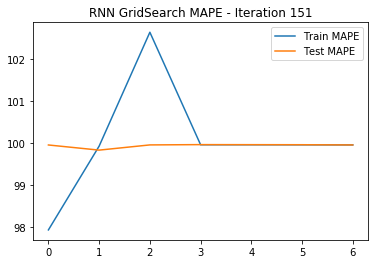

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 152, dtype: float64
Epoch 1/40
68/68 [==============================] - 188s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 2/40
68/68 [==============================] - 190s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 3/40
68/68 [==============================] - 191s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/40
68/68 [==============================] - 191s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 191s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00005: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
e

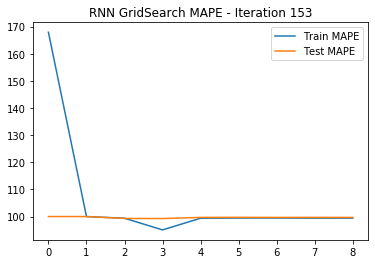

seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 154, dtype: float64
Epoch 1/40
68/68 [==============================] - 191s 3s/step - loss: 8370576896.0000 - mean_absolute_percentage_error: 99.8542 - val_loss: 8311064576.0000 - val_mean_absolute_percentage_error: 99.7163
Epoch 2/40
68/68 [==============================] - 190s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 3/40
68/68 [==============================] - 190s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 4/40
68/68 [==============================] - 192s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
68/68 [==============================] - 192s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 6/40
68/68 [==============================] - 191s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00006: early stopping
seq_length             168.000
seq_batch_size         256.000
layer_one_neurons      128.000
layer_two_neurons       64.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
e

Epoch 12/40
68/68 [==============================] - 227s 3s/step - loss: 852386688.0000 - mean_absolute_percentage_error: 25.8822 - val_loss: 395773824.0000 - val_mean_absolute_percentage_error: 15.4762
Epoch 00012: early stopping


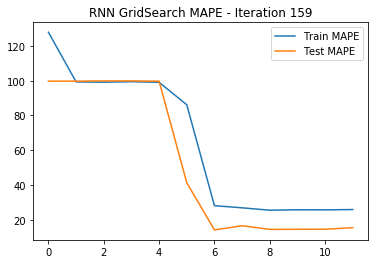

seq_length             168.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 160, dtype: float64
Epoch 1/40
34/34 [==============================] - 95s 3s/step - loss: 8390683648.0000 - mean_absolute_percentage_error: 99.9856 - val_loss: 8328401920.0000 - val_mean_absolute_percentage_error: 99.8267
Epoch 2/40
34/34 [==============================] - 94s 3s/step - loss: 8241866240.0000 - mean_absolute_percentage_error: 99.0299 - val_loss: 8002393600.0000 - val_mean_absolute_percentage_error: 97.7438
Epoch 3/40
34/34 [==============================] - 95s 3s/step - loss: 8045623808.0000 - mean_absolute_percentage_error: 97.7500 - val_loss: 8058135552.0000 - val_mean_absolute_percentage_error: 98.0920
Epoch 4/40
34/34 [==============================] - 

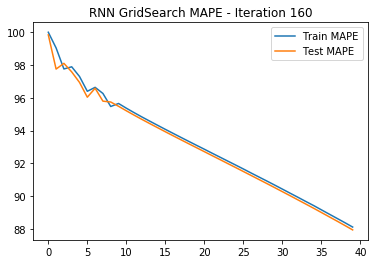

seq_length             168.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons       8.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 161, dtype: float64
Epoch 1/40
34/34 [==============================] - 95s 3s/step - loss: 8392823808.0000 - mean_absolute_percentage_error: 99.9998 - val_loss: 8355321344.0000 - val_mean_absolute_percentage_error: 99.9988
Epoch 2/40
34/34 [==============================] - 94s 3s/step - loss: 8366824448.0000 - mean_absolute_percentage_error: 99.8277 - val_loss: 8302429696.0000 - val_mean_absolute_percentage_error: 99.6620
Epoch 3/40
34/34 [==============================] - 94s 3s/step - loss: 8310975488.0000 - mean_absolute_percentage_error: 99.4763 - val_loss: 8306921472.0000 - val_mean_absolute_percentage_error: 99.6899
Epoch 4/40
34/34 [==============================] - 

C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 5/40
34/34 [==============================] - 94s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 6/40
34/34 [==============================] - 94s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 7/40
34/34 [==============================] - 94s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00007: early stopping
seq_length             168.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 162, dtype: float64
Epoch 1/40
34/34 [==============================] - 104s 3s/step - loss: 8391741440.0000 - mean_absolute_percentage_erro

Epoch 37/40
34/34 [==============================] - 109s 3s/step - loss: 142558208.0000 - mean_absolute_percentage_error: 10.0856 - val_loss: 178020928.0000 - val_mean_absolute_percentage_error: 10.4763
Epoch 38/40
34/34 [==============================] - 108s 3s/step - loss: 252324256.0000 - mean_absolute_percentage_error: 13.7935 - val_loss: 298388288.0000 - val_mean_absolute_percentage_error: 17.7309
Epoch 39/40
34/34 [==============================] - 107s 3s/step - loss: 156881360.0000 - mean_absolute_percentage_error: 10.9621 - val_loss: 128037944.0000 - val_mean_absolute_percentage_error: 9.9740
Epoch 40/40
34/34 [==============================] - 107s 3s/step - loss: 167288464.0000 - mean_absolute_percentage_error: 11.0632 - val_loss: 160690320.0000 - val_mean_absolute_percentage_error: 10.0736


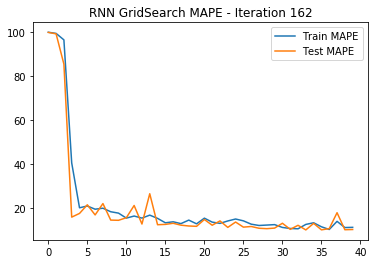

seq_length             168.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     16.000
layer_four_neurons      16.000
dropout_rate             0.200
stop_patience            5.000
learning_rate            0.001
epochs                  40.000
Name: 163, dtype: float64
Epoch 1/40
34/34 [==============================] - 105s 3s/step - loss: 8391558144.0000 - mean_absolute_percentage_error: 99.9917 - val_loss: 8345981440.0000 - val_mean_absolute_percentage_error: 99.9391
Epoch 2/40
34/34 [==============================] - 105s 3s/step - loss: 8121647104.0000 - mean_absolute_percentage_error: 98.0783 - val_loss: 8316074496.0000 - val_mean_absolute_percentage_error: 99.7487
Epoch 3/40
34/34 [==============================] - 106s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan


C:\Users\tawha\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


Epoch 4/40
34/34 [==============================] - 106s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 5/40
34/34 [==============================] - 106s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 6/40
34/34 [==============================] - 105s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 7/40
34/34 [==============================] - 105s 3s/step - loss: nan - mean_absolute_percentage_error: nan - val_loss: nan - val_mean_absolute_percentage_error: nan
Epoch 00007: early stopping
seq_length             168.000
seq_batch_size         512.000
layer_one_neurons       64.000
layer_two_neurons       32.000
layer_three_neurons     32.000
layer_four_neurons       8.000
dropout_rate             0.000
stop_patience            5.000
learning_rate            0.001
e

KeyboardInterrupt: 

In [44]:
print("\nBuilding and training models...")
tic = timeit.default_timer()

# Loop through all interactions of parameters from above
for i in df_params.index:
    print(df_params.iloc[i,:-4])
    
    # Set random seed
    random.seed(238)
    
    # Create training sequences
    train_sequences = TimeseriesGenerator(X_train_ss, y_train['value'],
                                          length = df_params['seq_length'][i],
                                          batch_size = df_params['seq_batch_size'][i])

    # Create test sequences
    test_sequences = TimeseriesGenerator(X_test_ss, y_test['value']
                                         , length = df_params['seq_length'][i]
                                         , batch_size = df_params['seq_batch_size'][i])

    ##### RNN MODEL #####
    # Instantiate model and construct all layers
    model = Sequential()
    model.add(GRU(df_params['layer_one_neurons'][i], input_shape = (df_params['seq_length'][i],75),
                  return_sequences = True, activation = 'relu', ))
    model.add(Dropout(df_params['dropout_rate'][i]))
    model.add(GRU(df_params['layer_two_neurons'][i], return_sequences = True, activation = 'relu'))
    model.add(Dropout(df_params['dropout_rate'][i]))
    model.add(GRU(df_params['layer_three_neurons'][i], return_sequences = True, activation = 'relu'))
    model.add(Dropout(df_params['dropout_rate'][i]))
    model.add(GRU(df_params['layer_four_neurons'][i], return_sequences = False, activation = 'relu'))
    model.add(Dropout(df_params['dropout_rate'][i]))
    model.add(Dense(1, activation = 'linear'))

    # Compile and fit model
    model.compile(optimizer = Adam(learning_rate = df_params['learning_rate'][i]),
                  loss = 'mean_squared_error',
                  metrics = 'mean_absolute_percentage_error')
    
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=df_params['stop_patience'][i], verbose=1, mode='auto')
    
    history = model.fit(train_sequences,
                        validation_data = test_sequences,
                        epochs = df_params['epochs'][i],
                        callbacks = [early_stop])
    
    if not np.isnan(history.history['loss'][-1]):
        # Add model performance results to parameters dataframe
        df_params.at[i,'mse_train'] = history.history['loss'][-1]
        df_params.at[i,'mse_test'] = history.history['val_loss'][-1]
        df_params.at[i,'mape_train'] = history.history['mean_absolute_percentage_error'][-1]
        df_params.at[i,'mape_test'] = history.history['val_mean_absolute_percentage_error'][-1]

        # Plot MAPE by epoch
        plt.plot(history.history['mean_absolute_percentage_error'], label = 'Train MAPE')
        plt.plot(history.history['val_mean_absolute_percentage_error'], label = 'Test MAPE')
        plt.title('RNN GridSearch MAPE - Iteration %s' % (i))
        plt.legend()
        plt.savefig('../Charts/RNN GridSearch MAPE - Iteration %s.png' % (i))
        plt.show();

toc = timeit.default_timer()
print('RNN grid search completed in %0.2f seconds' % (toc-tic))

In [46]:
# Write scores dataframes to CSV
df_params.to_csv('../Outputs/RNN_gridsearch_scores.csv')

### Investigate Model Results

In [100]:
df_params[(df_params['mape_train'] < 8) & (df_params['mape_test'] < 8) & (df_params['mape_train'] != 0)].sort_values('mse_test')

,seq_length,seq_batch_size,layer_one_neurons,layer_two_neurons,layer_three_neurons,layer_four_neurons,dropout_rate,stop_patience,learning_rate,epochs,mse_train,mse_test,mape_train,mape_test
22,24,256,128,32,32,16,0.0,5,0.001,40,42850132,44054740,5,5
46,24,512,64,64,32,16,0.0,5,0.001,40,35861144,54624784,5,6
38,24,512,64,32,32,16,0.0,5,0.001,40,50290220,59669468,6,6
26,24,256,128,64,16,16,0.0,5,0.001,40,43268892,61895568,5,7
56,24,512,128,64,16,8,0.0,5,0.001,40,65264088,62530520,6,6
36,24,512,64,32,32,8,0.0,5,0.001,40,49524500,63347268,6,6
14,24,256,64,64,32,16,0.0,5,0.001,40,58163124,64061272,6,7
12,24,256,64,64,32,8,0.0,5,0.001,40,56199272,69299768,6,7
16,24,256,128,32,16,8,0.0,5,0.001,40,80649416,69602336,7,7
2,24,256,64,32,16,16,0.0,5,0.001,40,49686680,71596640,6,7


> Confirm that the 168-hour recursion is unnecessary

In [49]:
df_params[(df_params['seq_length'] == 168) & (df_params['mape_train'] != 0)].sort_values('mape_test')

,seq_length,seq_batch_size,layer_one_neurons,layer_two_neurons,layer_three_neurons,layer_four_neurons,dropout_rate,stop_patience,learning_rate,epochs,mse_train,mse_test,mape_train,mape_test
162,168,512,64,32,16,16,0.0,5,0.001,40,167288464,160690320,11,10
159,168,256,128,64,32,16,0.2,5,0.001,40,852386688,395773824,25,15
138,168,256,64,64,16,16,0.0,5,0.001,40,311867776,295676416,15,17
131,168,256,64,32,16,16,0.2,5,0.001,40,886397568,1106514048,26,29
149,168,256,128,32,32,8,0.2,5,0.001,40,1353953152,4832908800,32,74
160,168,512,64,32,16,8,0.0,5,0.001,40,6622834176,6571335680,88,87
139,168,256,64,64,16,16,0.2,5,0.001,40,2795908864,6767620608,48,89
136,168,256,64,64,16,8,0.0,5,0.001,40,7782848000,7733798912,95,95
128,168,256,64,32,16,8,0.0,5,0.001,40,8344476160,8306493952,99,99
129,168,256,64,32,16,8,0.2,5,0.001,40,8390304768,8352989184,99,99


In [50]:
df_params[df_params['mape_train'] == 0]

,seq_length,seq_batch_size,layer_one_neurons,layer_two_neurons,layer_three_neurons,layer_four_neurons,dropout_rate,stop_patience,learning_rate,epochs,mse_train,mse_test,mape_train,mape_test
130,168,256,64,32,16,16,0.0,5,0.001,40,0,0,0,0
132,168,256,64,32,32,8,0.0,5,0.001,40,0,0,0,0
133,168,256,64,32,32,8,0.2,5,0.001,40,0,0,0,0
134,168,256,64,32,32,16,0.0,5,0.001,40,0,0,0,0
135,168,256,64,32,32,16,0.2,5,0.001,40,0,0,0,0
137,168,256,64,64,16,8,0.2,5,0.001,40,0,0,0,0
141,168,256,64,64,32,8,0.2,5,0.001,40,0,0,0,0
142,168,256,64,64,32,16,0.0,5,0.001,40,0,0,0,0
144,168,256,128,32,16,8,0.0,5,0.001,40,0,0,0,0
146,168,256,128,32,16,16,0.0,5,0.001,40,0,0,0,0


> Investigate the results without the missing iterations

In [61]:
# Filter results down to only the completed grid searches
df_results = df_params[df_params['mape_train'] != 0].copy()

# Set all search parameters as categorical
cat_columns = df_results.iloc[:,:-4].columns
for col in cat_columns:
    df_results[col] = df_results[col].astype('category')

''

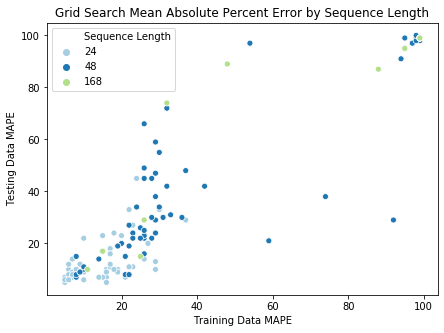

In [98]:
plt.figure(figsize = (7,5))
scatter_seq = sns.scatterplot(df_results['mape_train'],
                              df_results['mape_test'],
                              hue = df_results['seq_length'],
                              palette = 'Paired')

# Legend title fix from:
# https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title
scatter_seq.legend().texts[0].set_text("Sequence Length")
plt.title('Grid Search Mean Absolute Percent Error by Sequence Length')
plt.xlabel('Training Data MAPE')
plt.ylabel('Testing Data MAPE')
;

''

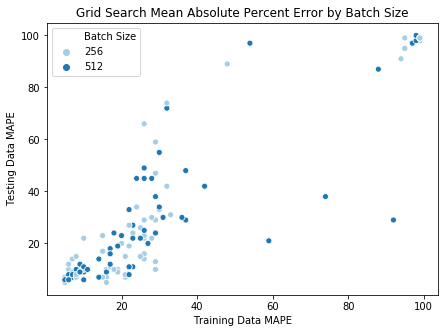

In [99]:
plt.figure(figsize = (7,5))
scatter_seq = sns.scatterplot(df_results['mape_train'],
                              df_results['mape_test'],
                              hue = df_results['seq_batch_size'],
                              palette = 'Paired')

# Legend title fix from:
# https://stackoverflow.com/questions/51579215/remove-seaborn-lineplot-legend-title
scatter_seq.legend().texts[0].set_text("Batch Size")
plt.title('Grid Search Mean Absolute Percent Error by Batch Size')
plt.xlabel('Training Data MAPE')
plt.ylabel('Testing Data MAPE')
;

> Select parameters for next grid search based on the lowest mean squared error from the testing dataset. Looking specifically at the lowest five MSE for the testing data and then confirming against the chart of MAPE by epoch.

In [102]:
df_results.sort_values('mse_test').head(5)

,seq_length,seq_batch_size,layer_one_neurons,layer_two_neurons,layer_three_neurons,layer_four_neurons,dropout_rate,stop_patience,learning_rate,epochs,mse_train,mse_test,mape_train,mape_test
22,24,256,128,32,32,16,0.0,5,0.001,40,42850132,44054740,5,5
31,24,256,128,64,32,16,0.2,5,0.001,40,341553152,44821752,16,5
46,24,512,64,64,32,16,0.0,5,0.001,40,35861144,54624784,5,6
38,24,512,64,32,32,16,0.0,5,0.001,40,50290220,59669468,6,6
26,24,256,128,64,16,16,0.0,5,0.001,40,43268892,61895568,5,7
